# Forecast of hydroelectric production in Portugal using XGBoost
---


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import xgboost as xgb
from hyperopt import Trials,tpe,hp,STATUS_OK,fmin
from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error,r2_score

1. Preprocessing of target variable

<Axes: title={'center': 'CF of Run of river hydroelectric generation of Portugal'}, xlabel='Date'>

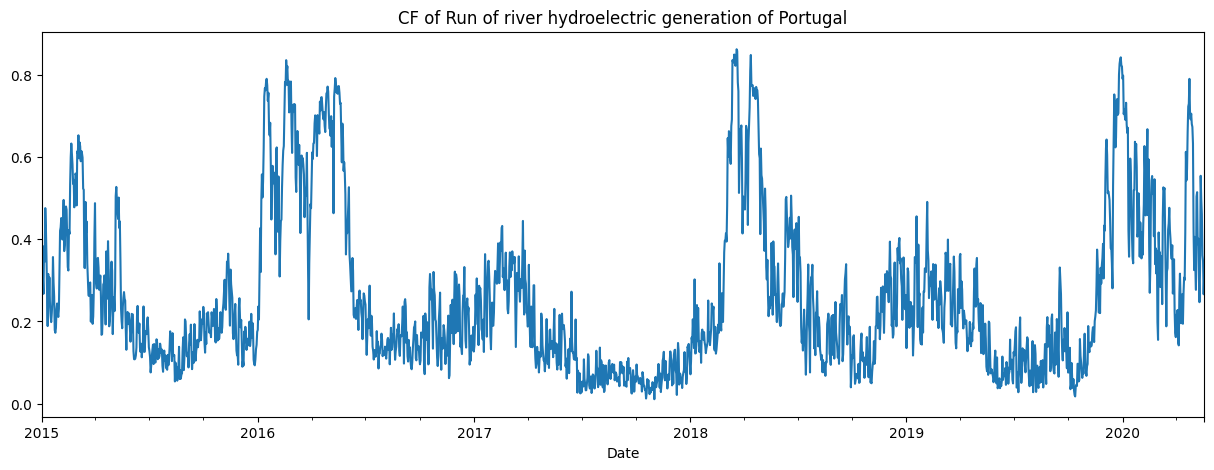

In [62]:
productionhydro=pd.read_csv(r"Data\HRO_tab.csv",
                      sep=";",
                      usecols=["Date","PT"],
                      dtype={"PT":np.float64}
                      )
productionhydro=productionhydro.set_index("Date")
productionhydro.index=pd.to_datetime(productionhydro.index,
                                     dayfirst=True)
productionhydro=productionhydro.squeeze()
productionhydro.name="prod"
productionhydro.plot(figsize=(15,5),
                     title="CF of Run of river hydroelectric generation of Portugal",
                     )

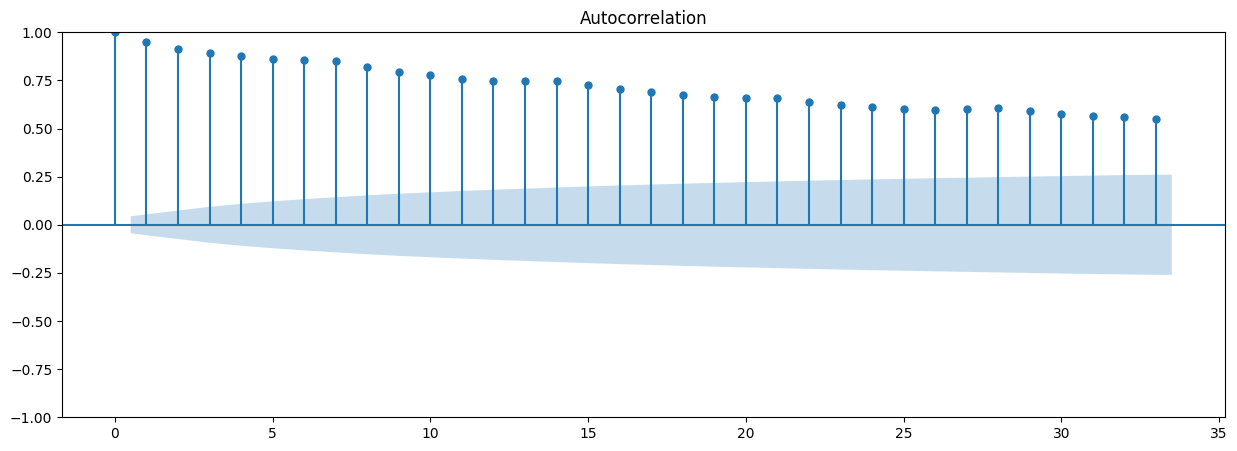

In [3]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
plot_acf(productionhydro,ax=ax)
plt.show()

As expected, the time serie is highly correlated with its past values. Using lags is therefore a good option. Now let's clean up the data.

<Axes: title={'center': 'boxplot of target variable'}>

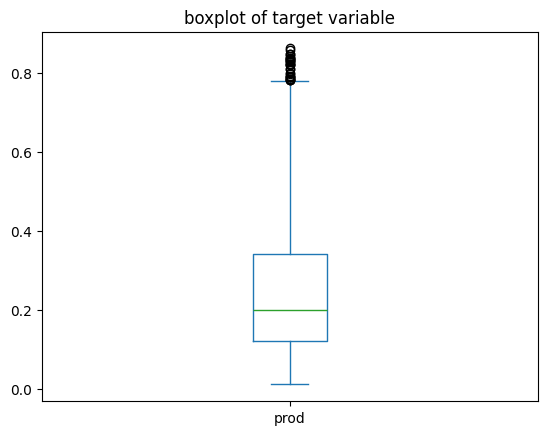

In [82]:
productionhydro.plot(kind="box",whis=2,title="boxplot of target variable")

In [5]:
def outliers_removal(data:pd.Series,coeff_interval:np.float32):
    """Quantile-based flooring and capping technique to clean data"""
    data=data.copy()
    #computation of interquartile range and bounds
    q1=productionhydro.quantile(0.25)
    q3=productionhydro.quantile(0.75)
    iqr=q3-q1
    lower_bound=q1-coeff_interval*iqr
    upper_bound=q3+coeff_interval*iqr
    #capping and flooring outliers
    data[data>upper_bound]=data.quantile(0.98)
    data[data<lower_bound]=data.quantile(0.2)
    return data

productionhydrocapped=outliers_removal(productionhydro,2)

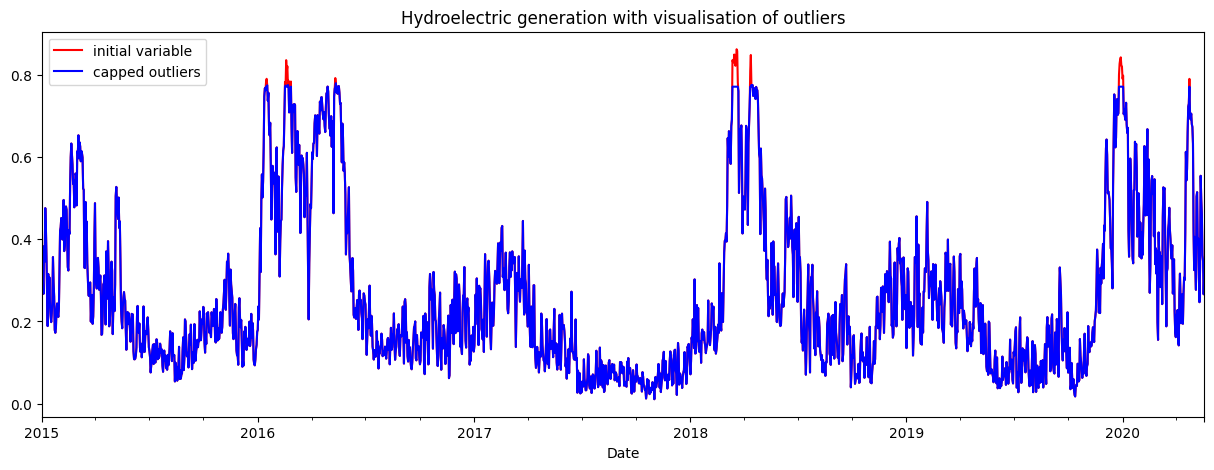

In [6]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
productionhydro.plot(ax=ax,
                     color='r',
                     title="Hydroelectric generation with visualisation of outliers",
                     label="initial variable"
                     )
productionhydrocapped.plot(ax=ax,
                            color="b",
                            label="capped outliers"
                            )
plt.legend()
plt.show()

Skewness coefficient = 1.1614453065772032


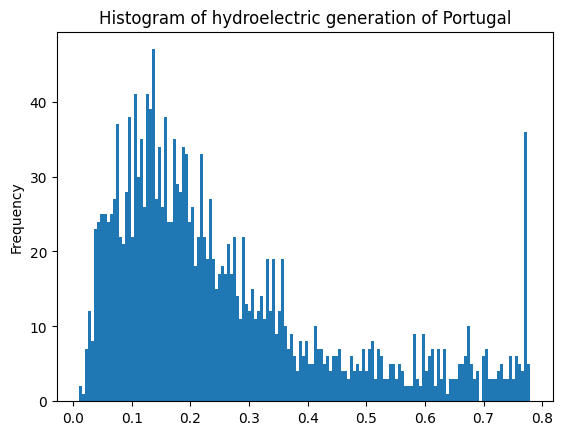

In [7]:
productionhydrocapped.plot.hist(bins=150,title="Histogram of hydroelectric generation of Portugal")
print(f"Skewness coefficient = {productionhydrocapped.skew().item()}")

In [8]:
print(f"number of value lower or equal to zero = {len(productionhydrocapped[productionhydrocapped<=0])}")

number of value lower or equal to zero = 0


In [9]:
productionhydrocleaned=np.sqrt(productionhydrocapped)

Skewness coefficient = 0.5532810612293783


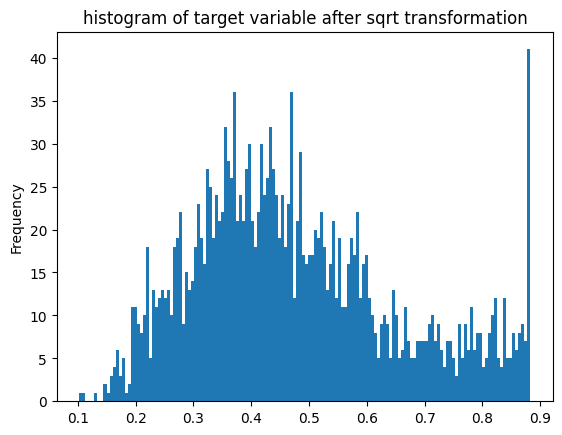

In [86]:
productionhydrocleaned.plot.hist(bins=150, title="histogram of target variable after sqrt transformation")
print(f"Skewness coefficient = {productionhydrocleaned.skew().item()}")

<Axes: title={'center': 'target variable after preprocessing'}, xlabel='Date'>

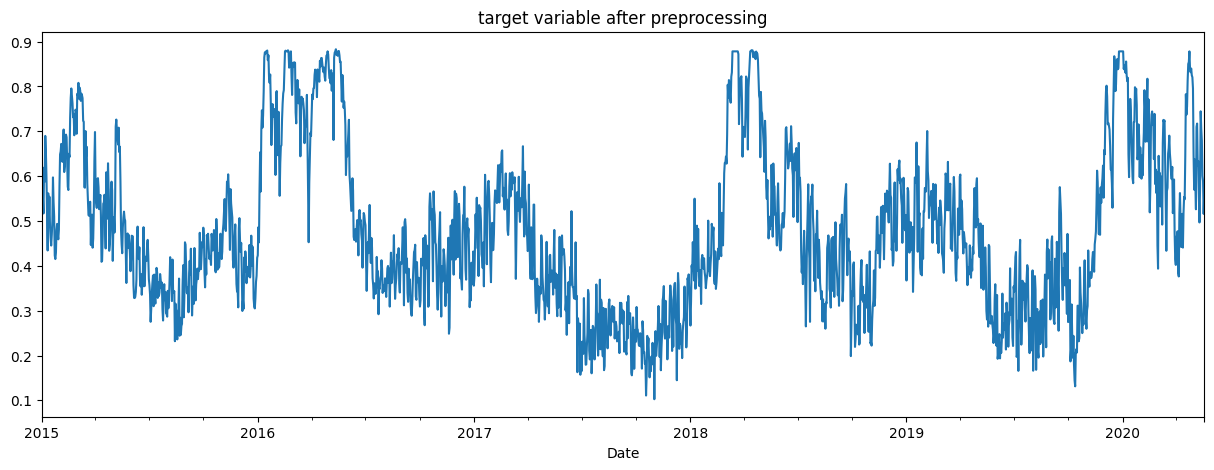

In [11]:
productionhydrocleaned.plot(figsize=(15,5),title="target variable after preprocessing")

2. Features and dataset creation

<Axes: title={'center': 'Power demand of portugal (no unit provided)'}, xlabel='Datetime'>

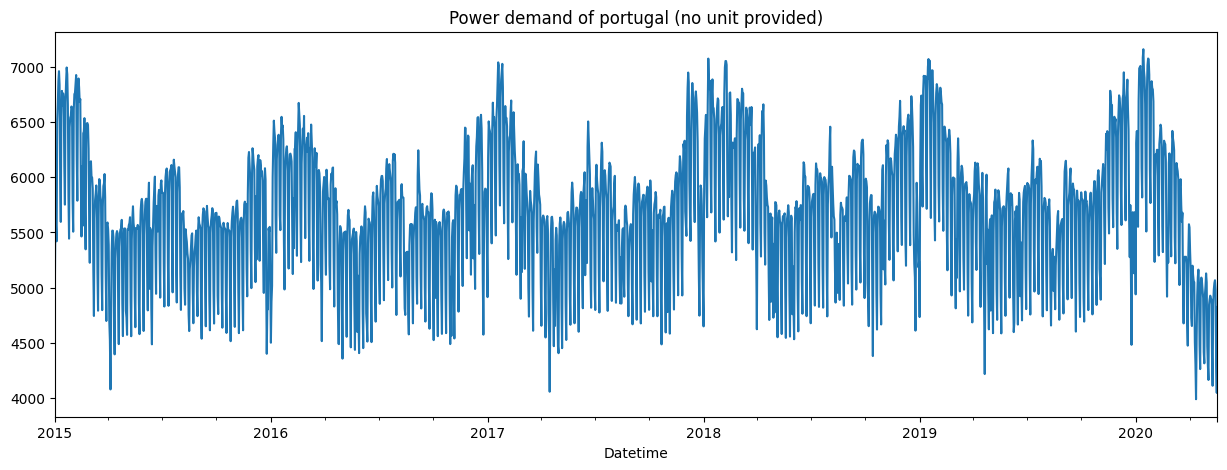

In [12]:
load=pd.read_csv(r"Data\Load.csv",
                 sep=";",
                 usecols=["Datetime","PT"]
                 )
load=load.set_index("Datetime")
load.index=pd.to_datetime(load.index,utc=False).tz_localize(None)
load=load.resample("D").mean()
load=load.squeeze()
load.name="load"
load.plot(figsize=(15,5),title="Power demand of portugal (no unit provided)")

<Axes: title={'center': 'Average temperature of Portugal (no unit provided)'}, xlabel='Date'>

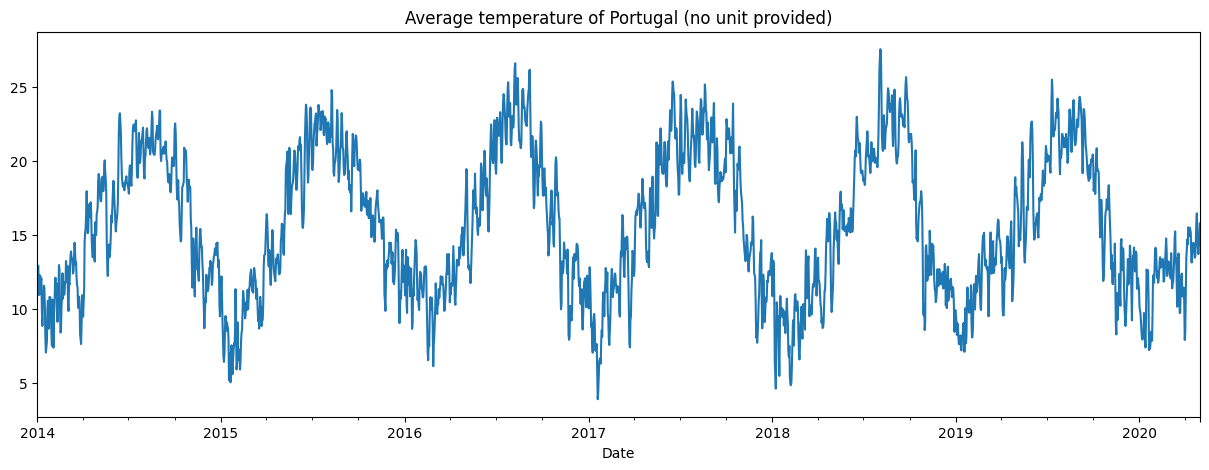

In [87]:
temperature=pd.read_csv(r'Data\TA_tab.csv',
                        sep=';',
                        usecols=['Date','PT11','PT15','PT16','PT17','PT18']
                        )
temperature=temperature.set_index("Date")
temperature.index=pd.to_datetime(temperature.index,dayfirst=True)
temperature=temperature.mean(axis=1).squeeze()
temperature.name="temperature"
temperature.plot(figsize=(15,5),title="Average temperature of Portugal (no unit provided)")

<Axes: title={'center': 'Average rainfall of Portugal (mm)'}, xlabel='Date'>

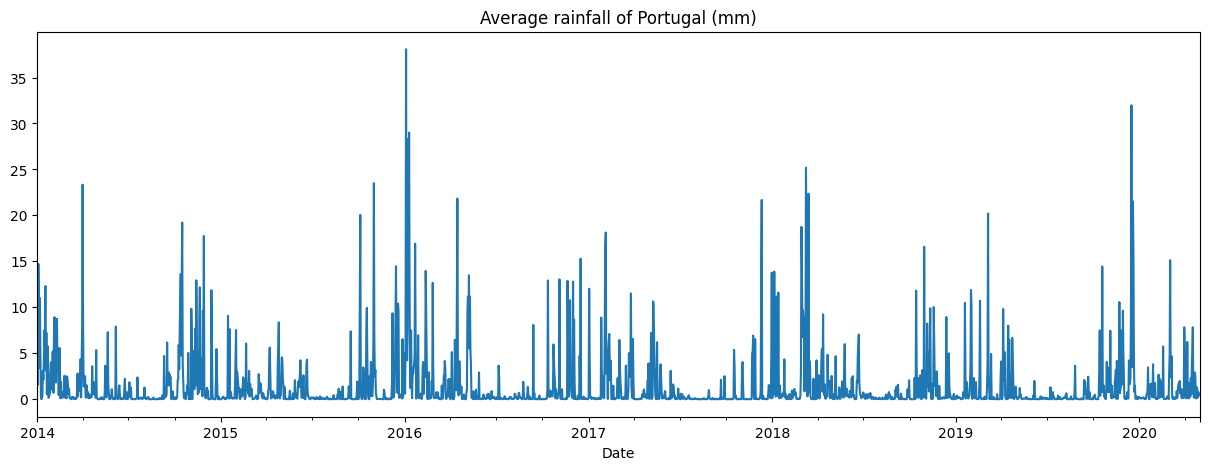

In [88]:
rainfall=pd.read_csv(r'Data\TP_tab.csv',
                        sep=';',
                        usecols=['Date','PT11','PT15','PT16','PT17','PT18']
                        )
rainfall=rainfall.set_index("Date")
rainfall.index=pd.to_datetime(rainfall.index,dayfirst=True)
rainfall=rainfall.mean(axis=1).squeeze()
rainfall.name="rainfall"
rainfall.plot(figsize=(15,5),title="Average rainfall of Portugal (mm)")

In [15]:
def add_temporal_features(df, daytime=True):
    """function that adds temporal features in the input dataframe"""
    
    df=df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['week']=df.index.isocalendar().week.astype("int").values
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['day'] = df.index.day
    
    if daytime:
        def time_of_day(hour):
            if hour>= 0 and hour<6:
                return "midnight"
            elif hour >= 6 and hour < 9:
                return "early_morning"
            elif hour>=9 and hour < 12:
                return "late_morning"
            elif hour>=12 and hour < 15:
                return "afternoon"
            elif hour >=15 and hour < 18:
                return "evening"
            else:
                return "night"
        
        df["time_of_day"]=(df["hour"].apply(time_of_day)).astype("category")

    return df

In [16]:
def add_lags(df,number_of_lags):
    for i in range(number_of_lags):
        df[f"lag_{i+1}"]=df["prod"].shift(i+1)
    return df

In [17]:
start_date=max(productionhydrocleaned.index.min(),load.index.min(),temperature.index.min(),rainfall.index.min())
end_date=min(productionhydrocleaned.index.max(),load.index.max(),temperature.index.max(),rainfall.index.max())
dataset=pd.concat([productionhydrocleaned.loc[(productionhydrocleaned.index>=start_date)&(productionhydrocleaned.index<=end_date)],
                   load.loc[(load.index>=start_date)&(load.index<=end_date)],
                   temperature.loc[(temperature.index>=start_date)&(temperature.index<=end_date)],
                   rainfall.loc[(rainfall.index>=start_date)&(rainfall.index<=end_date)]
                   ],axis=1)

In [23]:
dataset=add_temporal_features(dataset,daytime=False)
dataset=add_lags(dataset,5)
dataset=dataset.dropna()
dataset

,prod,load,temperature,rainfall,dayofweek,week,quarter,month,year,dayofyear,day,lag_1,lag_2,lag_3,lag_4,lag_5
2015-01-06,0.587637,6660.737500,6.766690,0.269533,1,2,1,1,2015,6,6,0.619040,0.516830,0.551185,0.598126,0.484211
2015-01-07,0.689817,6870.754167,6.419360,0.088891,2,2,1,1,2015,7,7,0.587637,0.619040,0.516830,0.551185,0.598126
2015-01-08,0.656632,6959.116667,6.984174,0.136671,3,2,1,1,2015,8,8,0.689817,0.587637,0.619040,0.516830,0.551185
2015-01-09,0.599321,6835.141667,8.602228,0.013978,4,2,1,1,2015,9,9,0.656632,0.689817,0.587637,0.619040,0.516830
2015-01-10,0.522352,5978.358333,9.524884,0.001305,5,2,1,1,2015,10,10,0.599321,0.656632,0.689817,0.587637,0.619040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-26,0.840112,4315.629167,14.287511,0.178645,6,17,2,4,2020,117,26,0.831876,0.840523,0.878339,0.854462,0.850309
2020-04-27,0.824897,4933.141667,13.708973,0.755857,0,18,2,4,2020,118,27,0.840112,0.831876,0.840523,0.878339,0.854462
2020-04-28,0.820608,5014.233333,14.220133,0.435347,1,18,2,4,2020,119,28,0.824897,0.840112,0.831876,0.840523,0.878339
2020-04-29,0.795633,5129.358333,14.608611,0.456161,2,18,2,4,2020,120,29,0.820608,0.824897,0.840112,0.831876,0.840523


3. Split

In [44]:
date_of_pred = dataset.index.max()-pd.DateOffset(months=1)

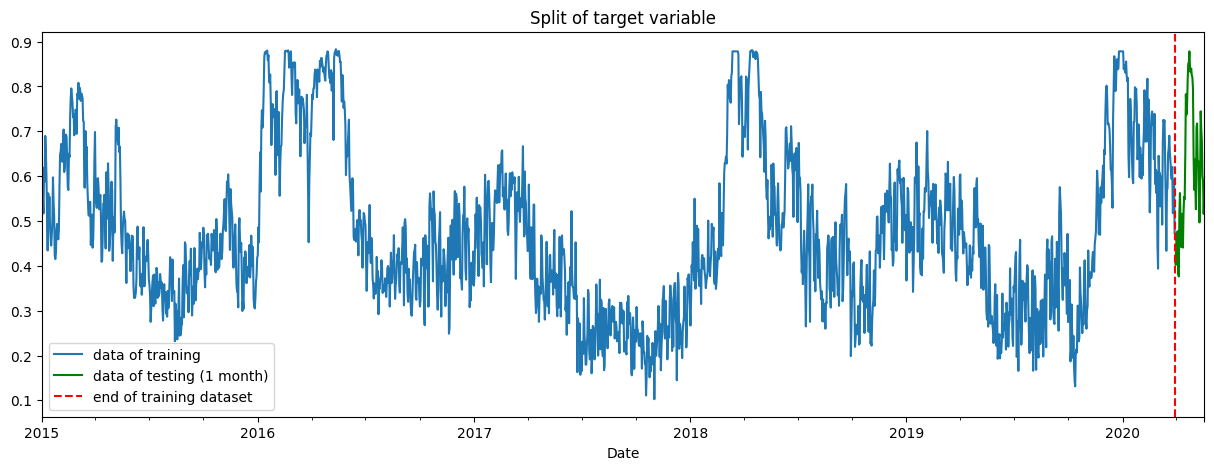

In [46]:
productionhydrocleaned.loc[productionhydrocleaned.index<date_of_pred].plot(figsize=(15,5), label='data of training', title='Split of target variable')
productionhydrocleaned.loc[productionhydrocleaned.index>=date_of_pred].plot(color="green", label='data of testing (1 month)')
plt.axvline(x = date_of_pred, 
            color = 'r',
            linestyle="dashed",
            label = 'end of training dataset'
            )
plt.legend()
plt.show()

In [47]:
y_train=dataset["prod"].loc[dataset.index<date_of_pred]
x_train=dataset.iloc[:,1:].loc[dataset.index<date_of_pred]
y_test=dataset["prod"].loc[dataset.index>=date_of_pred]
x_test=dataset.iloc[:,1:].loc[dataset.index>=date_of_pred]

4. Hyperparameter bayesian optimisation

In [48]:
space={
      'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.6)),
      'max_depth': hp.quniform("max_depth", 1, 8, 1),
      # 'gamma': hp.uniform ('gamma', 1,9),
      # 'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
      'colsample_bytree' : hp.uniform('colsample_bytree', 0.1,1),
      'min_child_weight' : hp.quniform('min_child_weight', 0, 5, 1),
      'n_estimators': hp.quniform('n_estimators', 100, 400, 50),
      # 'seed': 0,
      # 'early_stopping_rounds':10
      }

def objective(space):
        reg=xgb.XGBRegressor(
              learning_rate = space['learning_rate'],
              max_depth = int(space['max_depth']),
              colsample_bytree = int(space['colsample_bytree']),
              n_estimators = int(space['n_estimators']),
              min_child_weight = int(space['min_child_weight']),
              tree_method="hist",
              enable_categorical=False
              )
            
        evaluation = [(x_train, y_train), (x_test, y_test)]

        reg.fit(x_train, y_train,eval_set=evaluation, verbose=False)
            
        pred = reg.predict(x_test)
        score = root_mean_squared_error(y_test,pred)#r2_score(y_test_split,pred)
        #print (f"Score rmse = {score}")
        return {'loss': score, 'status': STATUS_OK }
        
trials = Trials()
hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
print(hyperparams)

100%|██████████| 100/100 [00:21<00:00,  4.66trial/s, best loss: 0.07469992831760049]
{'colsample_bytree': np.float64(0.29387442349435844), 'learning_rate': np.float64(0.2797584826245573), 'max_depth': np.float64(1.0), 'min_child_weight': np.float64(5.0), 'n_estimators': np.float64(200.0)}


5. Train and test

In [79]:
def forecast(target_train,features_train,features_test,hyperparameters):
    
    #Training
    regressor=xgb.XGBRegressor(
        colsample_bytree = hyperparameters["colsample_bytree"],
        learning_rate = hyperparameters["learning_rate"],
        max_depth = int(hyperparameters["max_depth"]),
        min_child_weight = int(hyperparameters['min_child_weight']),
        n_estimators = int(hyperparameters["n_estimators"])
        )

    regressor.fit(features_train, target_train, eval_set=[(features_train, target_train)],verbose=False)

    #Forecast and back-transformation
    y_pred = regressor.predict(features_test)
    y_pred=y_pred**2

    #Formatting
    pred = pd.Series(data=y_pred,
                     index=features_test.index,
                     name="xgboost estimation"
                     )
    return pred, regressor.feature_importances_

forecast_serie, features_importances = forecast(y_train,x_train,x_test,hyperparams)
reel_serie = productionhydro.loc[(productionhydro.index>=forecast_serie.index.min())&(productionhydro.index<=forecast_serie.index.max())]

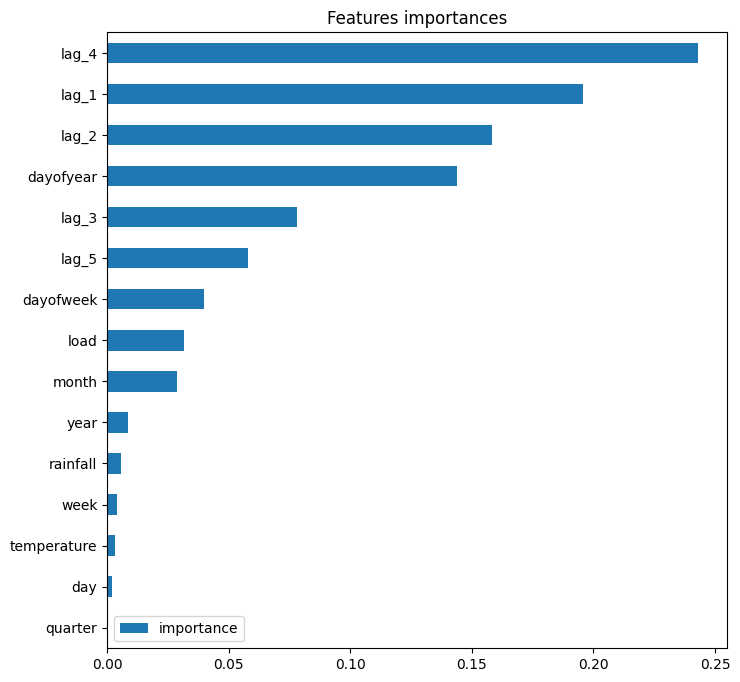

In [80]:
feature_importance_dataframe = pd.DataFrame(data=features_importances,
                                            index=x_test.columns,
                                            columns=['importance'])
feature_importance_dataframe.sort_values('importance').plot(kind='barh', title=f'Features importances',figsize=(8,8))
plt.show()

[]

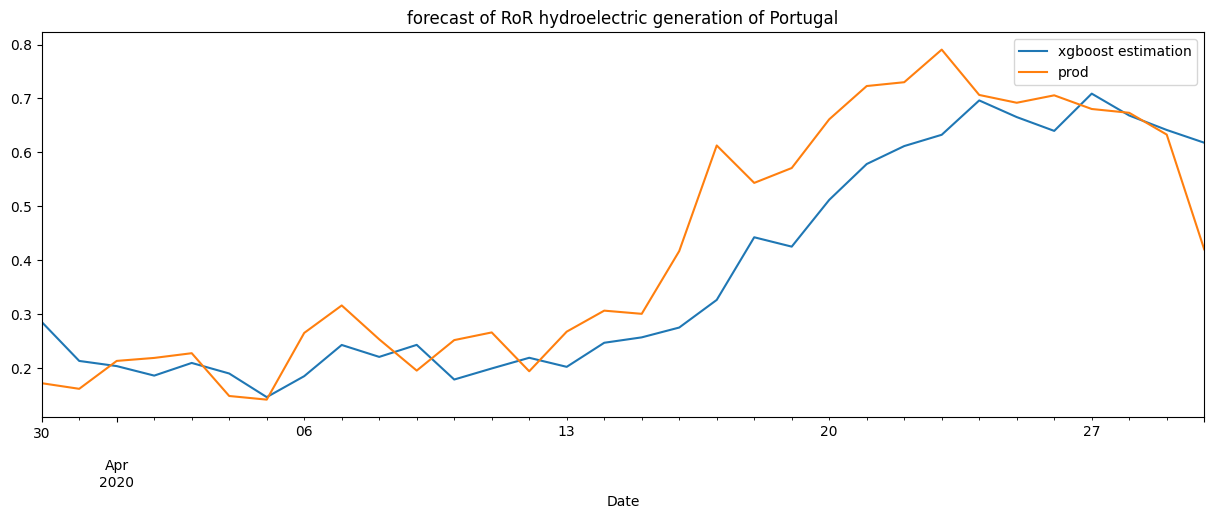

In [81]:
forecast_serie.plot(figsize=(15,5),title="forecast of RoR hydroelectric generation of Portugal")
reel_serie.plot()
plt.legend()
plt.plot()

6. Scores

In [69]:
print(f"RMSE = {root_mean_squared_error(reel_serie.values,forecast_serie.values)}")
print(f"R2 = {r2_score(reel_serie.values,forecast_serie.values)}")

RMSE = 0.0991951568024075
R2 = 0.7954625553893435


Xgboost does an excellent job. It is mainly because of the lags.